In [81]:
import os
import torch
import random
import datetime
import numpy as np
import pandas as pd
import torch.nn as nn
import pytorch_lightning as pl

from PIL import Image
from torch.optim import AdamW
from torchvision import models
import torch.nn.functional as F
from argparse import ArgumentParser
from matplotlib import pyplot as plt
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
import face_recognition
import cv2

attrs = pd.read_csv('data/list_attr_celeba.csv').replace(-1, 0)

classes = attrs.columns
n_classes = len(classes) - 1
id2class = {i:classes[i+1] for i in range(n_classes)}

In [124]:
class MultiTagMobileNet(pl.LightningModule):

    def __init__(self, n_classes):
        super().__init__()

        self.save_hyperparameters()
        self.n_classes = n_classes
        mnet = models.mobilenet_v2()

        # the input for the classifier should be two-dimensional, but we will have
        # [batch_size, channels, width, height]
        # so, let's do the spatial averaging: reduce width and height to 1
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.base_model = mnet.features
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=mnet.last_channel, out_features=n_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)
        # reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        x = torch.flatten(x, 1)

        return self.fc(x)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-3)
        scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=1e-1, patience=2, verbose=True)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

    def training_step(self, train_batch, batch_idx):
        # Img [bsz, w, h, c]
        img, attrs = train_batch
        # [bsz, n_classes]
        output = self.forward(img)

        train_loss = self.get_loss(output, attrs)
        return {'loss': train_loss}

    def validation_step(self, val_batch, batch_idx):
        img, attrs = val_batch
        output = self.forward(img)

        val_loss = self.get_loss(output, attrs)
        avg_acc, min_acc, max_acc = calculate_tag_metrics(output, attrs)

        return {"val_loss": val_loss, 'avg_acc': avg_acc, 'min_acc': min_acc, 'max_acc': max_acc}

    def validation_epoch_end(self, outputs):
        """"""
        val_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        avg_acc = sum([x['avg_acc'] for x in outputs]) / len(outputs)
        max_acc = max([x['max_acc'] for x in outputs])
        min_acc = min([x['min_acc'] for x in outputs])
        self.log("val_loss", val_loss, prog_bar=True, logger=True)
        self.log("avg_acc", avg_acc, prog_bar=True, logger=True)
        self.log("max_acc", max_acc, prog_bar=True, logger=True)
        self.log("min_acc", min_acc, prog_bar=True, logger=True)

    def get_loss(self, output, truth):
        loss = F.binary_cross_entropy(output, truth)
        return loss

model = MultiTagMobileNet.load_from_checkpoint('fx-epoch=03-val_loss=0.3702655.ckpt').cuda().eval()

In [3]:
# folder = 'img_align_celeba/img_align_celeba'

# imgs = [folder + "/" + f for f in sorted(folder)]
# attrs = pd.read_csv('list_attr_celeba.csv').replace(-1, 0)

# classes = attrs.columns
# n_classes = len(classes) - 1
# id2class = {i:classes[i+1] for i in range(n_classes)}


class CelebDataset(Dataset):
  def __init__(self,df,image_path,transform=None,mode='train'):
    super().__init__()
    self.attr=df.drop(['image_id'],axis=1)
    self.path=image_path
    self.image_id=df['image_id']
    self.transform=transform
    self.mode=mode
  
  def __len__(self):
    return self.image_id.shape[0]

  def __getitem__(self,idx:int):
    image_name=self.image_id.iloc[idx]
    image=Image.open(os.path.join(folder,image_name))
    attributes=np.asarray(self.attr.iloc[idx].T,dtype=np.float32)
    if self.transform:
      image=self.transform(image)
    return image, attributes    


# function to visualize dataset
def imshow(images,attr,idx:int):
    images=images.cpu().numpy().transpose((0,2,3,1))
    plt.imshow(images[idx] * std + mean)
    labels=attrs.columns.tolist()
    labels=labels[1:]
    att=attr[idx].numpy()
    labels=[label for label,a in list(zip(labels,att)) if a==1]
    plt.xlabel("\n".join(labels))
    plt.show()


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform=transforms.Compose([transforms.Resize((224,224)),
                  transforms.RandomVerticalFlip(p=0.5),
                  transforms.RandomHorizontalFlip(p=0.5),
                  transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=mean, std=std)])

valid_transform=transforms.Compose([transforms.Resize((224,224)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=mean, std=std)])

In [137]:
import face_recognition
import cv2
from datetime import datetime

starttime = datetime.now()

# Below includes some basic performance tweaks to make things run a lot faster:
#   1. Process each video frame at a smaller resolution (though still display it at full resolution)
#   2. Only detect faces in every other frame of video.

# Get a reference to webcam #0 (the default one)
video_capture = cv2.VideoCapture(0)

# Initialize some variables
# Extent of scaling up the upper bound
alpha = 2
# Extent of scaling up the other bounds
beta = 4
# Extent of reducing to speed up the process
reduce_level = 2
# Bool for processing other frame
process_this_frame = True
frame_counter = 0
tagging = True
face_attr_dict = {}

while True:
    # Grab a single frame of video
    ret, frame = video_capture.read()

    # Shape of the frame
    s_h, s_w, _ = frame.shape

    # Resize frame of video to 1/4 size for faster face recognition processing
    small_frame = cv2.resize(frame, (0, 0), fx=1/reduce_level, fy=1/reduce_level)

    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    rgb_small_frame = small_frame[:, :, ::-1]

    # Only process every other frame of video to save time
    if process_this_frame:
        frame_counter += 1
        # Find all the faces and face encodings in the current frame of video
        face_locations = face_recognition.face_locations(rgb_small_frame)
        
        # Display the results
        for face_id, (top, right, bottom, left) in enumerate(face_locations):
            
            # Scale back up face locations since the frame we detected in was scaled to 1/4 size
            top *= reduce_level
            right *= reduce_level
            bottom *= reduce_level
            left *= reduce_level

            h = bottom - top
            w = right - left

            # Add more margin of the box
            top = int(max(top - h / alpha, 0))
            left = int(max(left - w / beta, 0))
            bottom = int(min(bottom + h / beta, s_h - 1))
            right = int(min(right + w / beta, s_w - 1))

            rgb_frame_prediction = frame[:, :, ::-1]
            cropped_rgb_frame_prediction = rgb_frame_prediction[top:bottom, left:right]
            frame_tensor = valid_transform(Image.fromarray(cropped_rgb_frame_prediction)).unsqueeze(0).cuda()
            
            if frame_counter % 100==0:
                output = model.forward(frame_tensor)
                if tagging:
                    prediction = [np.squeeze(i) for i in np.array_split(np.array(output.cpu() > 0.48, dtype=float), 40, 1)]
                    temp_attr = []
                    for attr_index in range(len(prediction)):
                        attr = int(prediction[attr_index])
                        if attr:
                            temp_attr.append(id2class[attr_index].replace("_", " "))
                face_attr_dict[face_id] = temp_attr
                # else:
                #     prediction = [torch.argmax(i, dim=1).cpu() for i in output]
                #     for i in range(len(prediction)):
                #         feature_int = int(prediction[i])
                #         if feature_int:
                #             attrs_str[face_id].append(id2class[i].replace("_", " "))
                        
            #---------------draw box and text on frame--------------#
            # Draw a box around the face
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)
            
            # Draw a label with a name below the face
            
            
            font = cv2.FONT_HERSHEY_DUPLEX
            try:
                print(len(face_attr_dict[face_id]))
                for i in range(0, len(face_attr_dict[face_id]), 3):
                    face_attr_str = ", ".join(face_attr_dict[face_id][i:i+3])
                    cv2.putText(frame, face_attr_str, (left - 30, bottom + i*5+10), font, 0.6, (255, 255, 255), 1)
            except KeyError:
                cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
                cv2.putText(frame, "New Face Detected: ID"+ str(face_id), (left , bottom - 35), font, 0.6, (255, 255, 255), 1)

    # process_this_frame = not process_this_frame
    process_this_frame = True
    
    
    # Display the resulting image
    cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release handle to the webcam
video_capture.release()
cv2.destroyAllWindows()

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


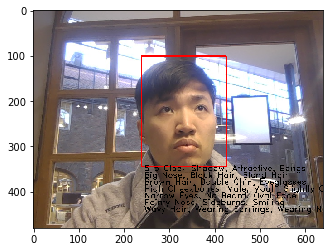

In [29]:
rgb_frame_prediction = frame[:, :, ::-1]

cropped_rgb_frame_prediction = rgb_frame_prediction[top:bottom, left:right]

plt.imshow(cropped_rgb_frame_prediction, interpolation='nearest')
plt.imshow(rgb_frame_prediction, interpolation='nearest')
frame_tensor = valid_transform(Image.fromarray(cropped_rgb_frame_prediction)).unsqueeze(0).cuda()
output = model.forward(frame_tensor)

prediction = [torch.argmax(i, dim=1).cpu() for i in output]

prediction_feature = []
for i in range(len(prediction)):
    feature_int = int(prediction[i])
    if feature_int:
        prediction_feature.append(id2class[i].replace("_", " "))
        
# prediction_feature

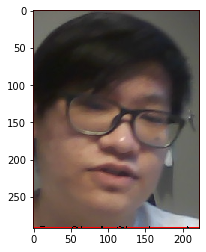

In [26]:
plt.imshow(cropped_rgb_frame_prediction, interpolation='nearest')

In [38]:
datapath = "data/"
pic_path = datapath + "img_align_celeba/img_align_celeba"

prediction: 18 :Arched Eyebrows, Attractive, Big Lips, Big Nose, Black Hair, Eyeglasses, Goatee, Male, Mouth Slightly Open, Mustache, Pointy Nose, Rosy Cheeks, Sideburns, Smiling, Wavy Hair, Wearing Earrings, Wearing Necklace, Young


true label 6 :5 o Clock Shadow, Bags Under Eyes, Male, Smiling, Straight Hair, Young


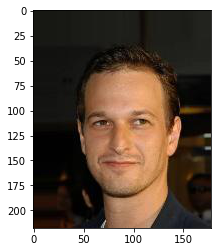

In [80]:
image = attrs.iloc[15]["image_id"]

frame = Image.open(pic_path + '/'+ image)

# rgb_frame_prediction = frame[:, :, ::-1]

# cropped_rgb_frame_prediction = rgb_frame_prediction[top:bottom, left:right]

# plt.imshow(cropped_rgb_frame_prediction, interpolation='nearest')
# plt.imshow(rgb_frame_prediction, interpolation='nearest')
frame_tensor = valid_transform(frame).unsqueeze(0).cuda()
output = model.forward(frame_tensor)
prediction = [torch.argmax(i, dim=1).cpu() for i in output]

prediction_feature = []
for i in range(len(prediction)):
    feature_int = int(prediction[i])
    if feature_int:
        prediction_feature.append(id2class[i].replace("_", " "))
plt.imshow(frame)
print("prediction: "+ str(len(prediction_feature))+ " :"+ ", ".join(prediction_feature))


print("\n")
answer = attrs[attrs["image_id"] == image].transpose()
answer_int = answer.iloc[:, 0]. tolist()[1:]
answer_list = []
for i in range(len(answer_int)):
    feature_int = int(answer_int[i])
    if feature_int:
        answer_list.append(id2class[i].replace("_", " "))
print("true label "+ str(len(answer_list))+ " :" + ", ".join(answer_list))

In [72]:
answer = attrs[attrs["image_id"] == "000015.jpg"].transpose()
answer_int = answer[14].to_list()[1:]

answer_list = []
for i in range(len(answer_int)):
    feature_int = int(answer_int[i])
    if feature_int:
        answer_list.append(id2class[i].replace("_", " "))
", ".join(answer_list)
# answer_list

'5 o Clock Shadow, Bags Under Eyes, Big Nose, Male, Narrow Eyes, No Beard, Straight Hair, Wearing Necktie'